### Phase difference stimulus modulation

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import jax
import seaborn as sns
import xarray as xr
from frites.conn.conn_sliding_windows import define_windows
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _create_kernel
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_model_nd_cd, gcmi_nd_cc, mi_nd_gg
from frites.core.gcmi_1d import gcmi_1d_cc
from frites.stats import confidence_interval
from mne.filter import filter_data
from mne.time_frequency import (
    CrossSpectralDensity,
    psd_array_multitaper,
    psd_array_welch,
    tfr_array_morlet,
)
from scipy.stats import (
    circmean,
    circstd,
    circvar,
    kruskal,
    ks_2samp,
    mannwhitneyu,
    ttest_ind,
)
from tqdm import tqdm

from src.session import session
from src.signal.surrogates import trial_swap_surrogates
from src.util import _extract_roi, get_dates

#### Functions

In [3]:
def z_score(x, dim=-1):
    return (x - x.mean(dim)[:, None]) / x.std(dim)[:, None]

In [4]:
def WrapToPi(x):
    xwrap = np.remainder(x, 2 * np.pi)
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    return xwrap

In [5]:
def node_xr_remove_sca(xar):
    sca = ["Caudate", "Claustrum", "Thal", "Putamen"]
    _, rois = _extract_roi(xar.roi.data, " ")
    idx = np.array([r in sca for r in rois])
    return xar.isel(roi=~idx)


def flatten(xss):
    return [x for xs in xss for x in xs]


def load_session_data(sid):

    # Instantiate class
    ses = session(
        raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
        monkey="lucy",
        date=sid,
        session=1,
        slvr_msmod=False,
        only_unique_recordings=False,
        align_to="cue",
        evt_dt=[-0.65, 1.5],
    )

    # Read data from .mat files
    ses.read_from_mat()

    # Filtering by trials
    data_task = ses.filter_trials(trial_type=[1], behavioral_response=[1])
    data_fixation = ses.filter_trials(trial_type=[2], behavioral_response=None)

    attrs_task, attrs_fixation = data_task.attrs, data_fixation.attrs

    stim = np.hstack((attrs_task["stim"], attrs_fixation["stim"]))
    t_cue_on = np.hstack((attrs_task["t_cue_on"], attrs_fixation["t_cue_on"]))
    t_cue_off = np.hstack((attrs_task["t_cue_off"], attrs_fixation["t_cue_off"]))
    t_match_on = np.hstack((attrs_task["t_match_on"], attrs_fixation["t_match_on"]))

    np.nan_to_num(stim, nan=6, copy=False)

    data = xr.concat((data_task, data_fixation), "trials")
    data.attrs = attrs_task
    data.attrs["stim"] = stim
    data.attrs["t_cue_on"] = t_cue_on
    data.attrs["t_cue_off"] = t_cue_off
    data.attrs["t_match_on"] = t_match_on

    # ROIs with channels
    rois = [
        f"{roi}_{channel}" for roi, channel in zip(data.roi.data, data.channels_labels)
    ]
    data = data.assign_coords({"roi": rois})
    # data.attrs = attrs
    data.values *= 1e6

    return data

In [6]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color="b",
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [7]:
def xr_psd_array_multitaper(data, bandwidth=1, n_jobs=1, fmin=0.1, fmax=80):
    trials, roi, time = data.trials.values, data.roi.values, data.time.values

    psds_c, freqs, _ = psd_array_multitaper(
        data,
        data.fsample,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
    )

    # Spectra
    sxx = (psds_c * np.conj(psds_c)).mean((0, 2)).real

    sxx = xr.DataArray(sxx, dims=("roi", "freqs"), coords=(roi, freqs))

    return sxx

In [8]:
from frites.conn import conn_io
from frites.io import check_attrs, logger, set_log_level
from frites.utils import parallel_func


def _coh(w, x_s, x_t, kw_para):
    """Pairwise coherence."""
    # auto spectra (faster that w * w.conj())
    s_auto = (w.real**2 + w.imag**2).mean((0, 2))

    # define the pairwise coherence
    def pairwise_coh(w_x, w_y):
        # computes the coherence
        s_xy = (w[:, w_y, :, :] * np.conj(w[:, w_x, :, :])).mean((0, 1))
        s_xx = s_auto[w_x]
        s_yy = s_auto[w_y]
        return np.abs(s_xy) ** 2 / (s_xx * s_yy)

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_coh, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def conn_spec_average(
    data,
    fmin=None,
    fmax=None,
    roi=None,
    sfreq=None,
    n_cycles=7.0,
    bandwidth=None,
    decim=1,
    kw_mt={},
    block_size=None,
    n_jobs=-1,
    verbose=None,
    dtype=np.float32,
    **kw_links,
):
    set_log_level(verbose)

    # _________________________________ INPUTS ________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})
    data, cfg = conn_io(
        data,
        times=None,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        block_size=block_size,
        sfreq=sfreq,
        freqs=None,
        foi=None,
        sm_times=None,
        sm_freqs=None,
        verbose=verbose,
        name=f"Spectral connectivity (metric = coh)",
        kw_links=kw_links,
    )

    # extract variables
    x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
    times, n_trials = data["times"].data, len(trials)
    x_s, x_t, roi_p = cfg["x_s"], cfg["x_t"], cfg["roi_p"]
    indices, sfreq = cfg["blocks"], cfg["sfreq"]
    n_pairs = len(x_s)

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    # temporal decimation
    times = times[::decim]

    # define arguments for parallel computing
    mesg = f"Estimating pairwise coh for trials %s"
    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    # show info
    logger.info(f"Computing pairwise coh (n_pairs={n_pairs}, " f"decim={decim}")

    # --------------------------- TIME-FREQUENCY --------------------------
    # time-frequency decomposition
    w, f_vec, _ = psd_array_multitaper(
        x[..., ::decim],
        sfreq,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
        **kw_mt,
    )
    # ______________________ CONTAINER FOR CONNECTIVITY _______________________
    dims = ("roi", "freqs")
    coords = (roi_p, f_vec)

    conn = _coh(w, x_s, x_t, kw_para)

    # configuration
    cfg = dict(
        sfreq=sfreq,
        n_cycles=n_cycles,
        mt_bandwidth=bandwidth,
        decim=decim,
    )

    # conversion
    conn = xr.DataArray(
        conn, dims=dims, name="coh", coords=coords, attrs=check_attrs({**attrs, **cfg})
    )
    return conn

In [9]:
def _phase_diff(w, x_s, x_t, kw_para):
    def pairwise_phase_diff(w_x, w_y):
        return np.unwrap(w[:, w_x, :, :] - w[:, w_y, :, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_phase_diff, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def hilbert_decomposition(
    data,
    sfreq=None,
    times=None,
    roi=None,
    bands=None,
    n_jobs=1,
    verbose=None,
    dtype=np.float32,
    **kw_links,
):
    """
    Docstring
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})
    data, cfg = conn_io(
        data,
        times=times,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        sfreq=sfreq,
        verbose=verbose,
        name=f"Hilbert Decomposition",
        kw_links=kw_links,
    )

    # Extract variables
    x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
    times, n_trials = data["times"].data, len(trials)
    x_s, x_t, roi_p, roi = cfg["x_s"], cfg["x_t"], cfg["roi_p"], data["roi"].data
    indices, sfreq = cfg["blocks"], cfg["sfreq"]
    n_pairs, f_vec, n_freqs = len(x_s), np.mean(bands, axis=1), len(bands)
    # If no bands are passed use broadband signal

    _dims = ("trials", "roi", "freqs", "times")
    _coord_nodes = (trials, roi, f_vec, times)
    _coord_links = (trials, roi_p, f_vec, times)

    # Filter data in the specified bands
    x_filt = []

    for f_low, f_high in bands:

        x_filt += [
            xr.DataArray(
                filter_data(x, sfreq, f_low, f_high, n_jobs=n_jobs, verbose=verbose),
                dims=data.dims,
                coords=data.coords,
                attrs=attrs,
            )
        ]

    x_filt = xr.concat(x_filt, "freqs").transpose("trials", "roi", "freqs", "times")

    # Hilbert coefficients
    h = scipy.signal.hilbert(x_filt, axis=3)

    # Compute phase-differences in parellel
    # show info
    logger.info(
        f"Computing pairwise phase difference (n_pairs={n_pairs}, " f"n_bands={n_freqs}"
    )
    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    h = xr.DataArray(
        h, dims=_dims, coords=_coord_nodes, attrs=attrs, name="analitical_signal"
    )

    return h

#### Setting configurations

In [10]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [11]:
metric = "coh"
monkey = "lucy"

In [12]:
sessions = get_dates(monkey)

#### Load data

In [13]:
data = load_session_data("141017")

In [14]:
data = data.isel(trials=data.attrs["stim"] != 6)
data.attrs["stim"] = data.attrs["stim"][data.attrs["stim"] != 6]

In [16]:
rois_sel = np.array([242, 163])
rois = data.roi.values
rois_idx = np.nonzero(np.in1d(data.channels_labels, rois_sel))[0]
data = data.isel(roi=rois_idx)

In [17]:
freqs = np.linspace(0.1, 80, 50)

W = tfr_array_morlet(
    data.values, 1000, freqs, freqs / 4, output="complex", n_jobs=1, zero_mean=False
)

W = xr.DataArray(
    W,
    dims=("trials", "roi", "freqs", "times"),
    coords=(
        data.trials,
        data.roi,
        freqs,
        data.time,
    ),
)

In [18]:
power_amplitude = np.abs(W)
complex_phase = W / power_amplitude
complex_phase_diff = complex_phase.isel(roi=0) * np.conj(complex_phase.isel(roi=1))


power_edge = np.stack(
    (power_amplitude.isel(roi=0), power_amplitude.isel(roi=1)), axis=1
)
phase_edge = np.stack((complex_phase_diff.real, complex_phase_diff.imag), axis=1)

In [19]:
stim = data.attrs["stim"].astype(int)

In [20]:
power_encoding = gcmi_model_nd_cd(power_edge, stim, mvaxis=1, traxis=0)
phase_encoding = gcmi_model_nd_cd(phase_edge, stim, mvaxis=1, traxis=0)

In [21]:
power_encoding = xr.DataArray(
    power_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="power encoding [bits]",
).squeeze()

phase_encoding = xr.DataArray(
    phase_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

Text(0.5, 1.0, 'Phase only')

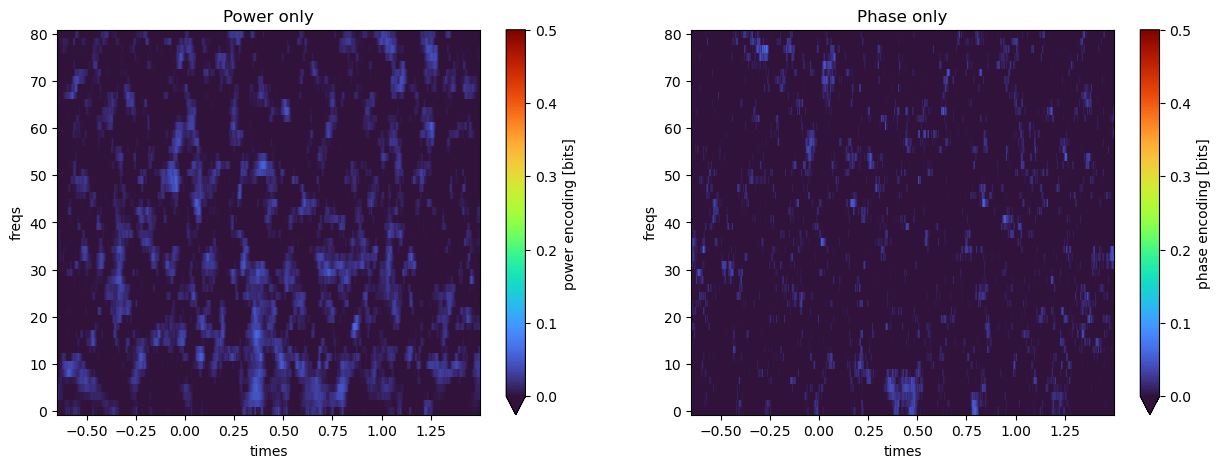

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
power_encoding.plot.imshow(cmap="turbo", vmin=0, vmax=.5)
plt.title("Power only")
plt.subplot(122)
phase_encoding.plot.imshow(cmap="turbo", vmin=0, vmax=.5)
plt.title("Phase only")

In [22]:
from hoi.core import get_mi

mi_fcn = get_mi("gcmi")

# vectorize the function to first and second dimension
gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

In [23]:
stim = data.attrs["stim"].astype(int)
stim = np.expand_dims(stim, axis=(0, 1))
stim = np.tile(stim, (len(freqs), W.sizes["times"], 1, 1))

In [24]:
power_edge = np.stack(
    (power_amplitude.isel(roi=0), power_amplitude.isel(roi=1)), axis=1
)
phase_edge = np.stack((complex_phase_diff.real, complex_phase_diff.imag), axis=1)

In [25]:
power_edge = np.moveaxis(copnorm_nd(power_edge, axis=1), [0, 1], [-1, -2])
phase_edge = np.moveaxis(copnorm_nd(phase_edge, axis=1), [0, 1], [-1, -2])

In [26]:
power_encoding = gcmi(power_edge, stim)
phase_encoding = gcmi(phase_edge, stim)

In [27]:
power_encoding = xr.DataArray(
    power_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="power encoding [bits]",
).squeeze()

phase_encoding = xr.DataArray(
    phase_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

Text(0.5, 1.0, 'Phase only')

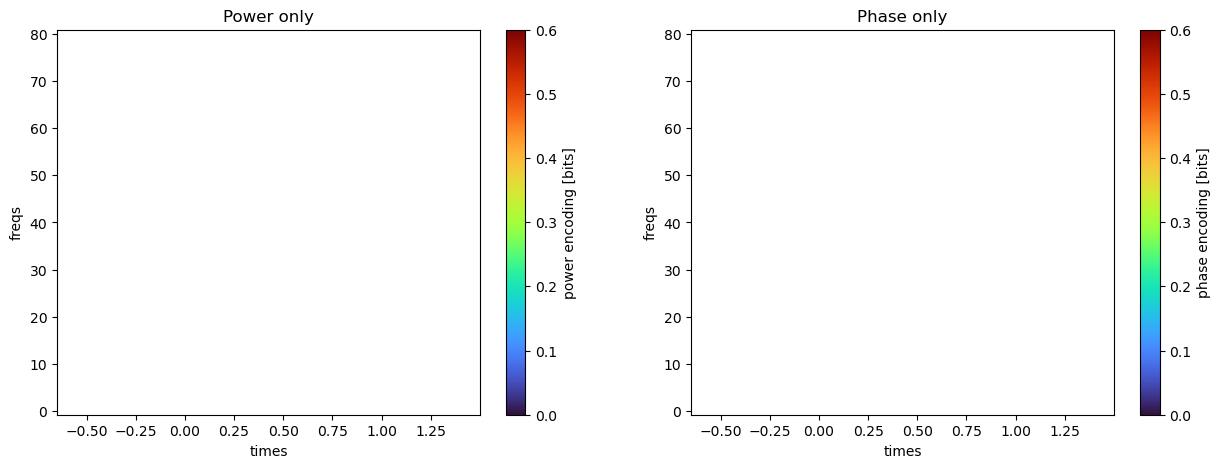

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
power_encoding.plot.imshow(cmap="turbo", vmin=0, vmax=0.6)
plt.title("Power only")
plt.subplot(122)
phase_encoding.plot.imshow(cmap="turbo", vmin=0, vmax=0.6)
plt.title("Phase only")

In [30]:
power_encoding

<xarray.DataArray 'power encoding [bits]' (freqs: 50, times: 2150)> Size: 430kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * freqs    (freqs) float64 400B 0.1 1.731 3.361 4.992 ... 76.74 78.37 80.0
  * times    (times) float64 17kB -0.65 -0.649 -0.648 ... 1.497 1.498 1.499